In [2]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt

In [64]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, batch_size=32, shuffle=False, sample_size=None, train_test_split=False, test_size=.2, file_list=None, name='Generator'):
        self.batch_size = batch_size
        self.dir = directory
        self.shuffle = shuffle
        self.sample_size = sample_size
        self.test_size = test_size
        if file_list == None:
            self._files = self.__get_images_from_directory(directory)
        else:
            try:
                self._files = self.__collect_image_files(file_list)
            except TypeError:
                print('file_list is not a list')
       
        
        if train_test_split:
            self.__train_test_split(self._files)
        else:
            print(f'Found {len(self._files)} files for {name} set')
        self.size = len(self._files)      
        self.on_epoch_end()

    def __len__(self):
        return len(self._files) // self.batch_size

    def __getitem__(self, index):
        batch = self._files[index*self.batch_size:index*self.batch_size+self.batch_size]
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            shuffle(self._files)
        
        
    def __get_data(self, batch):
        X = np.empty((self.batch_size, 128, 512, 1))

        for i, file in enumerate(batch):
            path = self.dir + file
            img = tf.keras.preprocessing.image.load_img(path, color_mode='grayscale')
            scale = 1./255
            X[i,] = tf.convert_to_tensor(scale*np.array(tf.keras.preprocessing.image.img_to_array(img))) 
            
        y = X

        return X, y
    
    def take(self, index=1):
        
        return self.__getitem__(num)
    
    def __train_test_split(self, files):
        
        if self.shuffle:
            shuffle(files)
            
        file_list_length = len(files)
        test_split = int(file_list_length * (1 - self.test_size))
        
        train_files = files[:test_split]
        test_files = files[test_split:]
        
        self.train = DataGenerator(self.dir, shuffle=self.shuffle, file_list=train_files, name='Training')
        self.test = DataGenerator(self.dir, shuffle=self.shuffle, file_list=test_files, name='Test')
        
        
    def __collect_image_files(self, files):
        filetypes = ['png', 'jpg', 'jpeg', 'webp']
        return [file for file in files if file.split('.')[-1] in filetypes]
    
    def __get_images_from_directory(self, directory):
        files = os.listdir(directory)
        
        files = self.__collect_image_files(files)
        
        if self.shuffle:
            shuffle(files)
        
        if self.sample_size != None:
            files = sample(files, self.sample_size)
        
        return files

In [73]:
data_gen = DataGenerator(directory='data/Spotify/pngs/', batch_size=32, shuffle=True, sample_size=10000, train_test_split=True, test_size=.05)

Found 9500 files for Training set
Found 500 files for Test set


In [71]:
autoencoder = tf.keras.models.load_model('data/autoencoder1')

In [74]:
hist = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/10
296/296 [==============================] - 817s 3s/step - loss: 0.0148 - val_loss: 0.0193
Epoch 2/10
231/296 [======================>.......] - ETA: 3:00 - loss: 0.0146

KeyboardInterrupt: 

In [56]:
prediction_gen = DataGenerator(directory='data/Spotify/pngs/', batch_size=1, shuffle=False)

Found 160962 files for Generator set


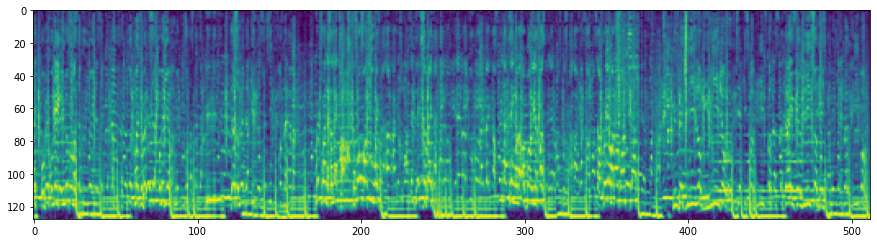

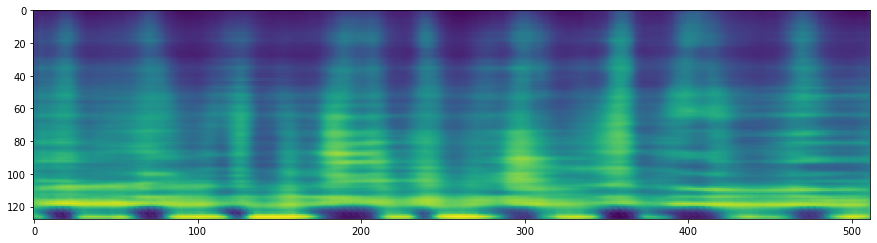

In [68]:
test_img = prediction_gen.take(234)[0]

prediction = autoencoder(test_img)

plt.figure(figsize=(15,5))
plt.imshow(test_img[0])
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(np.array(prediction[0]*255))